In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import clear_output
from tqdm.notebook import tqdm
import os
from pathlib import Path

import torch
import numpy as np

import cv2
import matplotlib.pyplot as plt

In [2]:
import torch
from pytorch3d.renderer.points.pulsar import Renderer

In [3]:
PYTHON_PATHS = ["../.."]
import sys
for path in PYTHON_PATHS:
    if path not in sys.path:
        sys.path.append(path)
        
from imap.utils import UniversalFactory
from pytorch_lightning.utilities.parsing import AttributeDict
from imap.data.datasets.tum.tum_dataset_loader_factory import TUMDatasetLoaderFactory
from imap.model.nerf import NERF
from imap.model.embeddings.gaussian_positional_encoding import GaussianPositionalEncoding
from imap.model.embeddings.gaussian_positional_embedding import GaussianPositionalEmbedding
from imap.trainers.trainers import ModelTrainer
from imap.model.active_sampling.image_active_sampling import ImageActiveSampling
from imap.utils.utils import *

from imap.utils.image_renderer import ImageRenderer

In [4]:
dataset_params = {'dataset_path': "/home/quetalasj/datasets/TUM RGBD/", 
                  'scene_name': "rgbd_dataset_freiburg1_desk", 
                  'association_file_name': "data_association_file.txt", 
                  'frame_indices': [*range(0,40,1)],
                  'distance_koef': 0.1,
                  'clip_distance_threshold': 4.}
camera_info, dataset_loader = TUMDatasetLoaderFactory.make_dataset_loader(**dataset_params)

Reading /home/quetalasj/datasets/TUM RGBD/rgbd_dataset_freiburg1_desk/data_association_file.txt


In [5]:
model_parameters = AttributeDict(
    name="NERF",
    course_sample_bins=32,
    fine_sample_bins=12,
    depth_loss_koef=1.,
    color_loss_koef=5.,
    minimal_depth=0.01,
    positional_embedding = AttributeDict(
                                        name = 'GaussianPositionalEmbedding',
                                        encoding_dimension=93,
                                        sigma=25,
                                        use_only_sin=False,
                                        use_bias=True
                                        )
)

factory = UniversalFactory([NERF, GaussianPositionalEncoding, GaussianPositionalEmbedding])
model = factory.make_from_parameters(model_parameters, camera_info=camera_info)

In [55]:
model.cuda()
model.train()

image_active_sampler = ImageActiveSampling(camera_info, points_per_frame=200)
trainer = ModelTrainer(image_active_sampler)

trainer.train_model(model, dataset_loader, 100, is_image_active_sampling=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [7]:
image_renderer = ImageRenderer(camera_info)
model.eval()
color_coarse_images, depth_coarse_images, color_fine_images, depth_fine_images = [], [], [], []
i=10
for state in dataset_loader:

    position_to_render = state.get_matrix_position().to('cuda')
    
    color_coarse_image, depth_coarse_image, color_fine_image, depth_fine_image = image_renderer.render_output(model, position_to_render)
    color_coarse_images.append(color_coarse_image)
    depth_coarse_images.append(depth_coarse_image)
    color_fine_images.append(color_fine_image)
    depth_fine_images.append(depth_fine_image)
    i -=1
    if i <0:
        break
torch.cuda.empty_cache()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

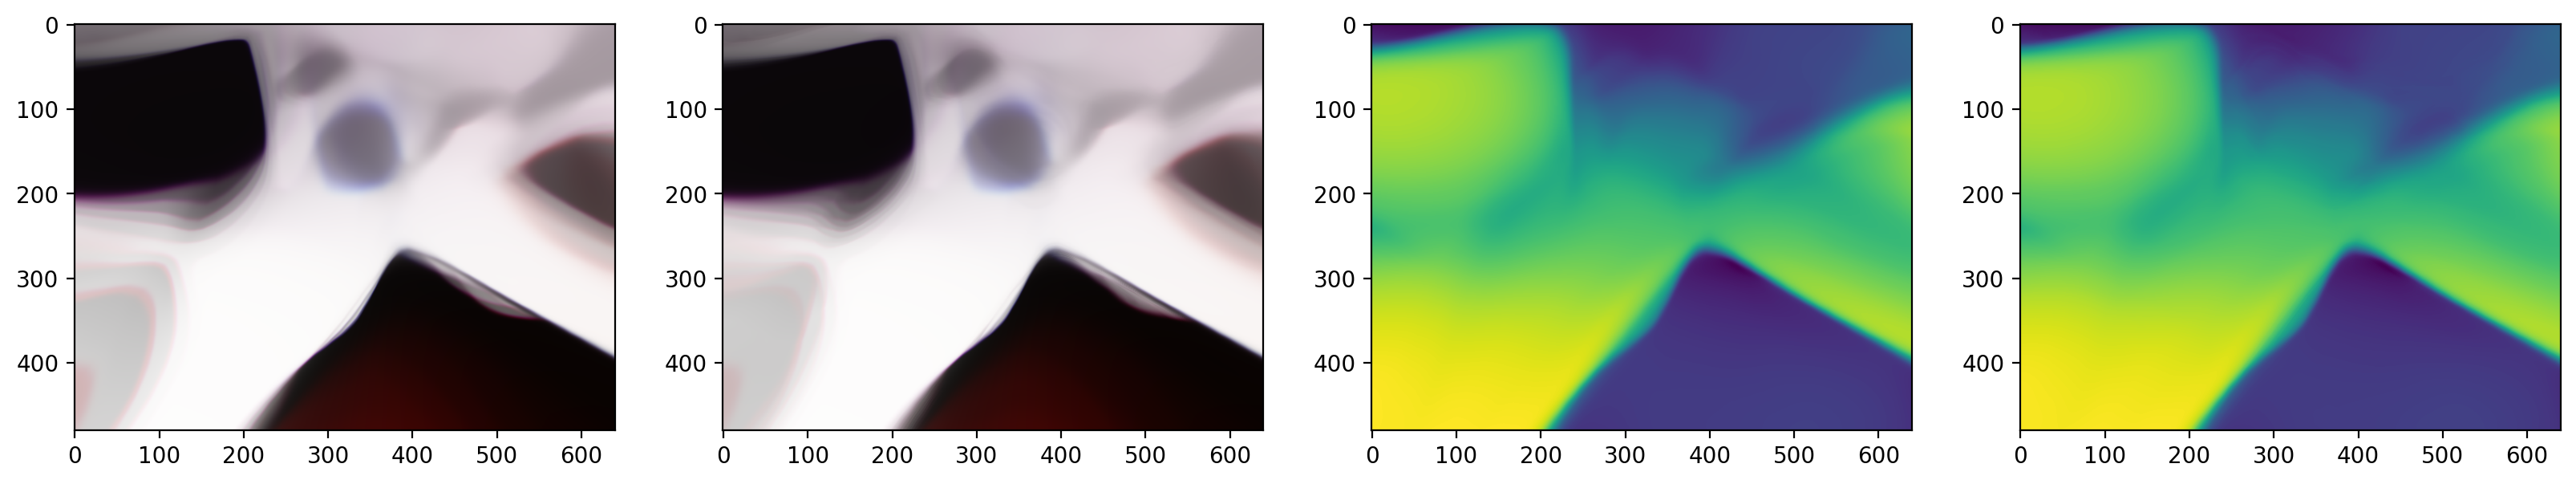

In [8]:
indx = 0
figure = plt.figure(dpi=200, figsize=(20,18))
plt.subplot(1,4,1)
plt.imshow(cv2.cvtColor(color_coarse_images[indx], cv2.COLOR_RGB2BGR))


plt.subplot(1,4,2)
plt.imshow(cv2.cvtColor(color_fine_images[indx], cv2.COLOR_RGB2BGR))

plt.subplot(1,4,3)
plt.imshow(1. /depth_coarse_images[indx])


plt.subplot(1,4,4)
plt.imshow(1. /depth_fine_images[indx])

In [9]:
# import imageio

In [10]:
# cam_params = torch.tensor(list(dataset_loader[0]._position) + [0.0525, 640.0], dtype=torch.float32)
# print(cam_params)

In [11]:
# Generate sample data.
# n_points=10
# vert_pos = torch.rand(n_points, 3, dtype=torch.float32, device="cpu") * 10.0
# vert_pos[:, 2] += 25.0
# vert_pos[:, :2] -= 5.0
# vert_col = torch.rand(n_points, 3, dtype=torch.float32, device="cpu")
# vert_rad = torch.rand(n_points, dtype=torch.float32, device="cpu")

In [12]:
# cam_params = torch.tensor(
#     [
#         0.0,
#         0.0,
#         0.0,  # Position 0, 0, 0 (x, y, z).
#         0.0,
#         math.pi,  # Because of the right handed system, the camera must look 'back'.
#         0.0,  # Rotation 0, 0, 0 (in axis-angle format).
#         5.0,  # Focal length in world size.
#         2.0,  # Sensor size in world size.
#     ],
#     dtype=torch.float32,
# )

In [13]:
# n_points = 10
# width = 640
# height = 480

# # The PyTorch3D system is right handed; in pulsar you can choose the handedness.
# # For easy reproducibility we use a right handed coordinate system here.
# renderer = Renderer(width, height, n_points, right_handed_system=True).to('cpu')


# # Render.
# image = renderer(
#     vert_pos.to('cpu'),
#     vert_col.to('cpu'),
#     vert_rad.to('cpu'),
#     cam_params.to('cpu'),
#     1.0e-1,  # Renderer blending parameter gamma, in [1., 1e-5].
#     45.0,  # Maximum depth.
# )

# imageio.imsave("basic.png", (image.cpu().detach() * 255.0).to(torch.uint8).numpy())
# print("Done.")

In [56]:
from pytorch3d.structures import Pointclouds

In [6]:
from imap.utils.image_renderer import ImageRenderer
image_renderer = ImageRenderer(camera_info)

In [7]:
data_pixels = image_renderer._generate_image_frame()

In [58]:
from imap.utils.torch_math import back_project_pixel

In [107]:
def f(model, image_renderer, position):
    colors_arr = []
    densities_arr = []
    coords = []
    model.eval()
    model.cpu()
    data_pixels = image_renderer._generate_image_frame()
    device = next(model.parameters()).device
    for i in range(data_pixels.shape[0] // image_renderer.batch_size):
        data_batch = data_pixels[i * image_renderer.batch_size :
                            i * image_renderer.batch_size + image_renderer.batch_size].to(device)

        course_sampled_depths = model.stratified_sample_depths(data_batch.shape[0],
                                    data_batch.device,
                                    model.course_sample_bins,
                                    not model.training)

        bins_count = course_sampled_depths.shape[0]
        course_sampled_depths = torch.sort(course_sampled_depths, dim=0).values
        course_sampled_depths = course_sampled_depths.reshape(-1)
        pixels = model.repeat_tensor(data_batch, bins_count)

        back_projected_points = back_project_pixel(pixels, course_sampled_depths, position.T.cpu(),
                                                   model._inverted_camera_matrix)
        encodings = model._positional_encoding(back_projected_points)
        prediction = model._mlp(encodings)

        colors = torch.sigmoid(prediction[:, :3])#.reshape(bins_count, -1, 3)
        density = prediction[:, 3]#.reshape(bins_count, -1)
        
        coords.append(back_projected_points.detach().cpu())
        colors_arr.append(colors.detach().cpu())
        densities_arr.append(density.detach().cpu()[...,None])
    del data_batch
    return colors_arr, densities_arr, coords

In [60]:
from pytorch3d.renderer.points.pulsar.unified import PulsarPointsRenderer

In [61]:
from pytorch3d.renderer import (
    look_at_view_transform,
    PerspectiveCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor
)


In [62]:
cameras = PerspectiveCameras(focal_length=525.0,
                             principal_point=((319.5, 239.5),),
                                              
                            R=dataset_loader[0].get_matrix_position().detach().cpu()[:3, :3].T[None,:,:],
                            T=-(dataset_loader[0].get_matrix_position().detach().cpu()[:3, :3] @  dataset_loader[0].get_matrix_position().detach().cpu()[3,:3])[None,:],
                            image_size=((480, 640),),
                            in_ndc=False,
                            device='cuda')

In [108]:
position = dataset_loader[0].get_matrix_position().detach().cpu()
colors_arr, densities_arr, coords = f(model, image_renderer, position)

point_cloud = Pointclouds(points=torch.cat(coords)[None,:,:], features=torch.cat(colors_arr)[None,:])

In [105]:
torch.cat(coords)[None,:,:].shape

torch.Size([1, 9830400, 3])

In [110]:
torch.cat(densities_arr).shape

torch.Size([9830400, 1])

In [111]:
point_cloud2 = Pointclouds(points=torch.cat(coords)[None,:,:], features=torch.cat(densities_arr)[None,:])

In [64]:
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene

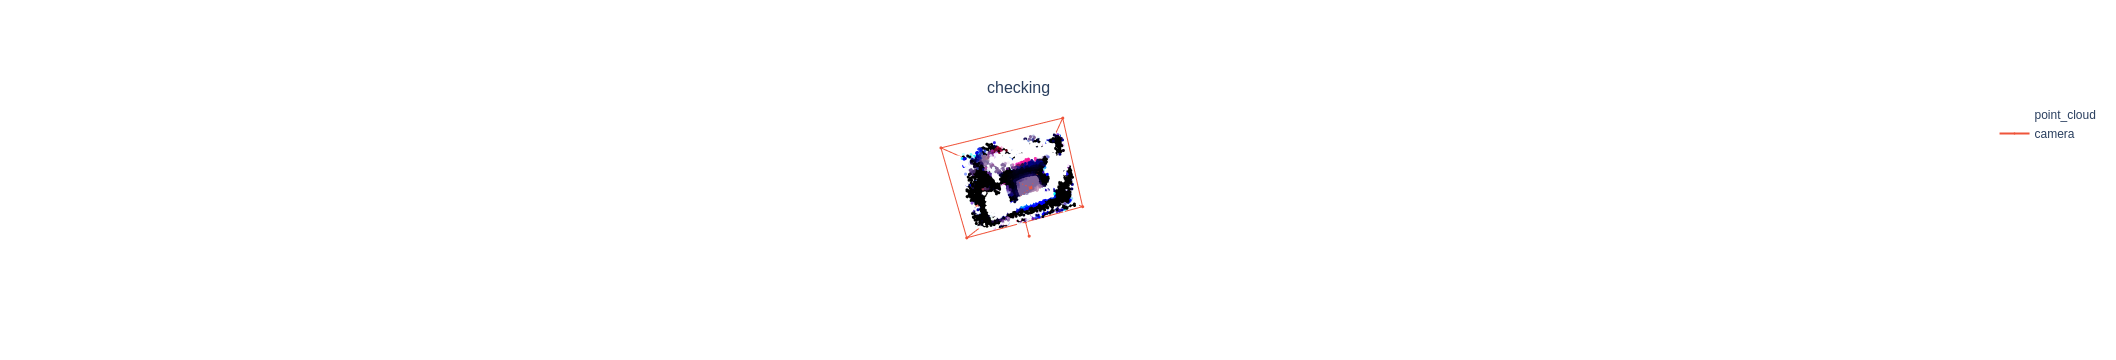

In [65]:
# Render the plotly figure
fig = plot_scene({
    "checking": {
        "point_cloud": point_cloud,
        "camera": cameras
    }
})
fig.show()

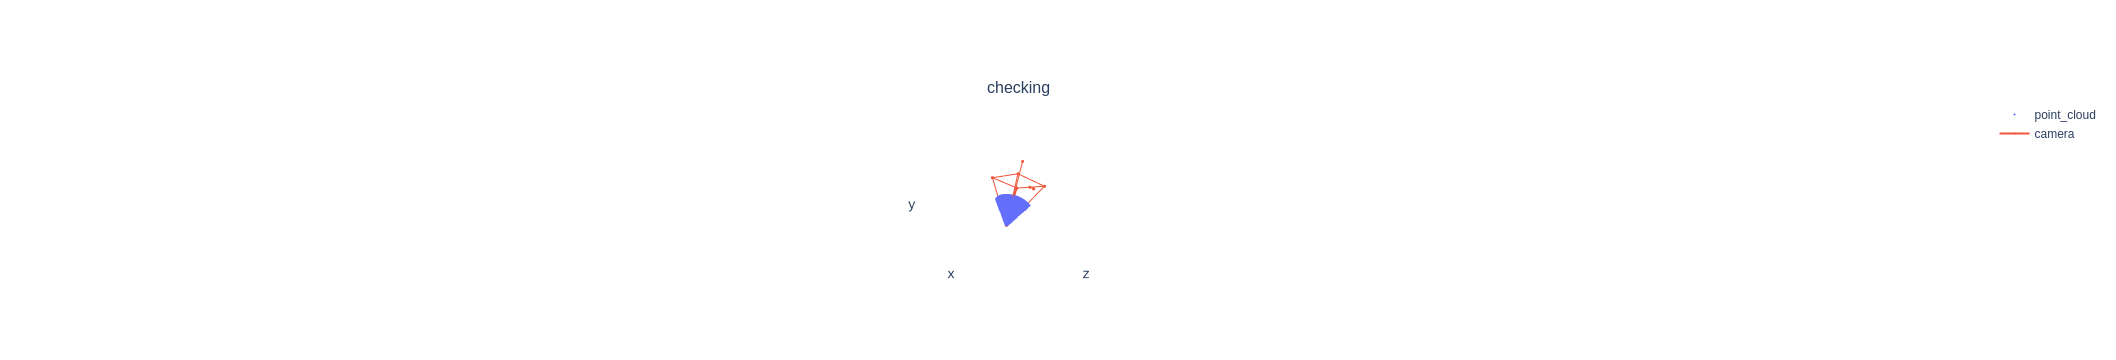

In [112]:
# Render the plotly figure
fig = plot_scene({
    "checking": {
        "point_cloud": point_cloud2,
        "camera": cameras
    }
})
fig.show()

In [74]:
raster_settings = PointsRasterizationSettings(
    # image_size=(480, 640), 
    radius = 0.003,
    points_per_pixel = 150
)
rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)

renderer = PointsRenderer(
    rasterizer=rasterizer,
    compositor=NormWeightedCompositor()
)

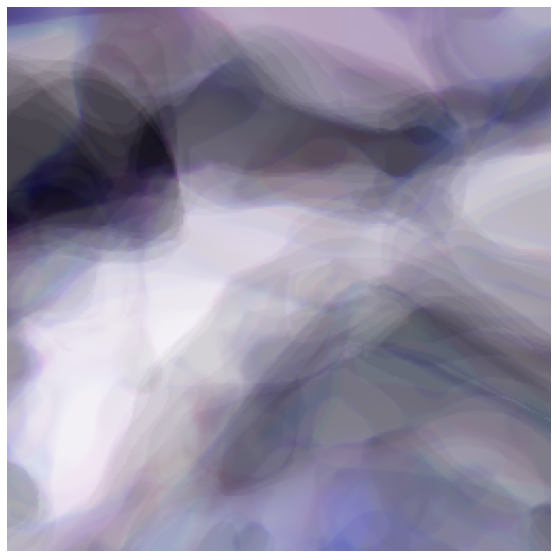

In [75]:

torch.cuda.empty_cache()
images = renderer(point_cloud.cuda()).cpu().numpy()

torch.cuda.empty_cache()


plt.figure(figsize=(10, 10))
plt.imshow(np.flip(images[0, ..., :3], (0,1)))
plt.axis("off");